In [38]:

# import required libraries
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math
import socket

import os
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs


# Local File Imports
from parse_bin_output import *

In [16]:
rawData = np.load("/Users/wolf/dev/437taus23/final_project/radar/raw/data_11_30_2023_18_21_53.npy")

In [17]:
data = np.array([frame["adcSamples"][:, 128:] for frame in rawData])

In [20]:
print(data.shape)
# Step 1: Extract the second chirp
second_chirp_data = data[:, 1, :]

(450, 3, 128)


In [21]:
# Step 2: Compute the Range Profile
# FFT across the sample dimension
range_profile = np.fft.fft(second_chirp_data, axis=0)

# Step 3: Compute the Range-Doppler Profile
# FFT across the chirp dimension
range_doppler_profile = np.fft.fft(data, axis=1)

# Step 4: Compute the Range-Angle Profile
# FFT across the antenna dimension
range_angle_profile = np.fft.fft(data, axis=2)

In [ ]:
# Step 1: Normalization
# Normalize the data to a [0, 1] range
normalized_data = range_doppler_profile - np.min(range_doppler_profile)
normalized_data = normalized_data / np.max(normalized_data)

# Step 2: Noise Reduction
# Apply a simple thresholding method to reduce noise
# Set a threshold value, e.g., 0.1, which might need adjustment based on your data
threshold_value = 0.1
noise_reduced_data = np.where(normalized_data > threshold_value, normalized_data, 0)

# Step 3: Further Thresholding (Optional)
# You can apply a more aggressive thresholding if needed
# For example, keeping only the top 5% of values
percentile_threshold = 95
high_value_threshold = np.percentile(noise_reduced_data, percentile_threshold)
thresholded_data = np.where(noise_reduced_data > high_value_threshold, noise_reduced_data, 0)

In [ ]:
# Step 1: Pre-process the Data
# This can include normalization, thresholding, etc.
processed_data = np.abs(range_doppler_profile)

# Flatten the data as KMeans expects 2D input
X = processed_data.reshape(-1, 1)

# Step 2: Apply K-Means Clustering
# Using the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):  # Test for 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the results of the Elbow Method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster Sum of Squares
plt.show()

# Choose the number of clusters (k) based on the Elbow plot
# and rerun KMeans with this number
k_optimal = 3  # Example, replace with your chosen value based on the plot
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Step 3: Post-Processing
# Additional filtering criteria can be applied here

# The number of clusters found by KMeans can be interpreted as the number of people
num_people_detected = k_optimal
print("Number of people detected:", num_people_detected)

In [24]:
rawData = np.load("/Users/wolf/dev/437taus23/final_project/radar/raw/data_11_30_2023_18_21_53.npy")
data = np.array([frame["adcSamples"][:, 128:] for frame in rawData])

In [25]:
# Compute the Range Profile
# FFT along the samples per chirp axis (axis=2)
range_profile = np.fft.fft(data, axis=2)

In [26]:
# Compute the Range-Doppler Profile
# FFT along the chirps axis (axis=0)
range_doppler_profile = np.fft.fft(range_profile, axis=0)

# You might also want to shift the zero-frequency component to the center
range_doppler_profile = np.fft.fftshift(range_doppler_profile, axes=0)

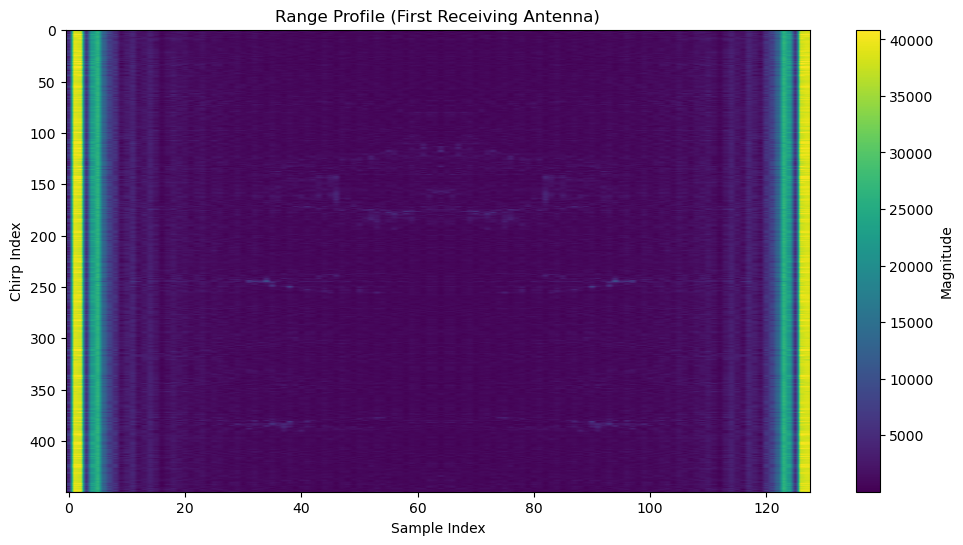

In [27]:
# Visualize the Range Profile
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(range_profile[:,0,:]), aspect='auto')  # Visualizing for the first receiving antenna
plt.title('Range Profile (First Receiving Antenna)')
plt.xlabel('Sample Index')
plt.ylabel('Chirp Index')
plt.colorbar(label='Magnitude')
plt.show()

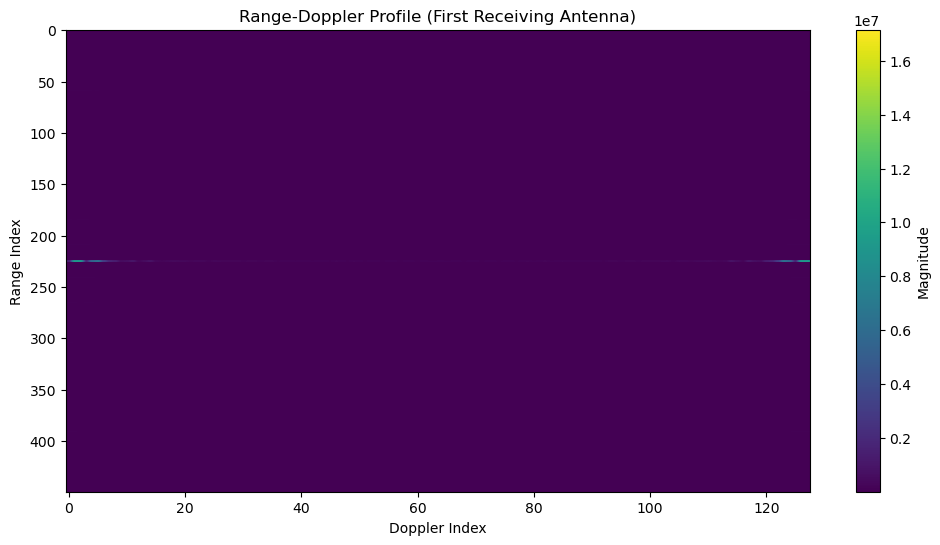

In [29]:
# Visualize the Range-Doppler Profile
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(range_doppler_profile[:,1,:]), aspect='auto')  # Visualizing for the first receiving antenna
plt.title('Range-Doppler Profile (First Receiving Antenna)')
plt.xlabel('Doppler Index')
plt.ylabel('Range Index')
plt.colorbar(label='Magnitude')
plt.show()

In [30]:
# Preprocess the data
magnitude = np.abs(range_doppler_profile)
threshold = np.percentile(magnitude, 95)  # adjust the percentile as needed
significant_points = np.argwhere(magnitude > threshold)

In [32]:
from sklearn.preprocessing import StandardScaler
# Feature Scaling
scaler = StandardScaler()
significant_points_scaled = scaler.fit_transform(significant_points)

In [33]:
from sklearn.cluster import KMeans
# Determine the optimal number of clusters using the Elbow Method
sum_of_squared_distances = []
K = range(1, 10)  # Adjust the range as needed
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(significant_points_scaled)
    sum_of_squared_distances.append(km.inertia_)

/Users/wolf/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wolf/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wolf/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wolf/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

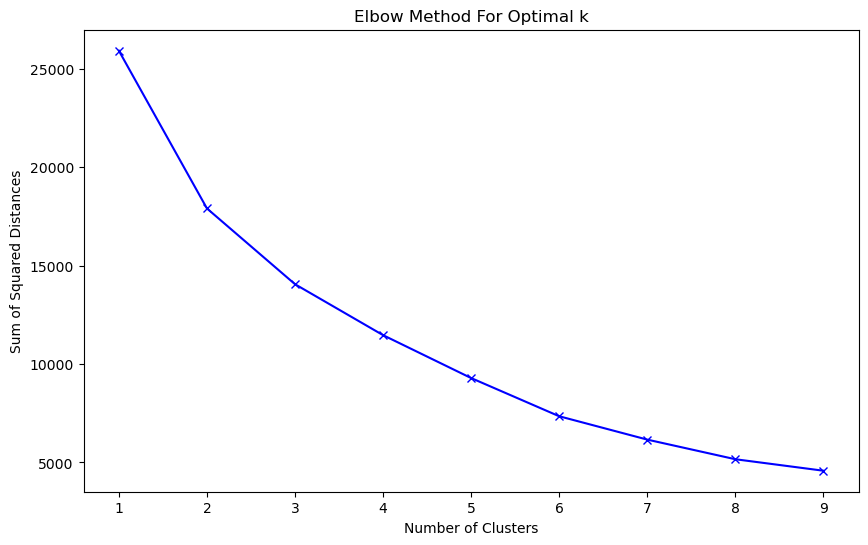

In [34]:
# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [35]:
# This should be done manually by observing the plot
optimal_k = 4  # Replace with the chosen number based on the plot

# Apply K-Means Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(significant_points_scaled)

/Users/wolf/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

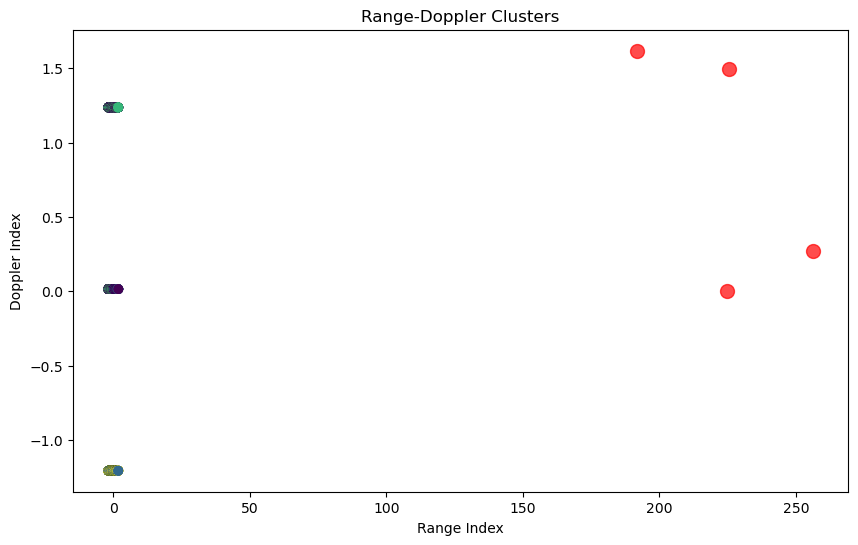

In [36]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(significant_points_scaled[:, 0], significant_points_scaled[:, 1], c=kmeans.labels_, cmap='viridis')
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.7)  # Cluster centers
plt.title('Range-Doppler Clusters')
plt.xlabel('Range Index')
plt.ylabel('Doppler Index')
plt.show()

In [37]:
# Estimating the number of people
num_people = len(np.unique(kmeans.labels_))
print(f'Estimated number of people: {num_people}')

Estimated number of people: 4


In [66]:
file = 'data/pHistBytes_6.npy'

In [67]:
rawData = np.load(file)
data = np.array([frame["adcSamples"][:, 128:] for frame in rawData])

# Compute the Range Profile
# FFT along the samples per chirp axis (axis=2)
range_profile = np.fft.fft(data, axis=2)

# Compute the Range-Doppler Profile
# FFT along the chirps axis (axis=0)
range_doppler_profile = np.fft.fft(range_profile, axis=0)

# You might also want to shift the zero-frequency component to the center
range_doppler_profile = np.fft.fftshift(range_doppler_profile, axes=0)

from sklearn.cluster import DBSCAN
from scipy.ndimage import median_filter

# Assuming 'range_doppler_profile' is the computed profile

# Preprocess the data: Apply median filter to reduce noise
filtered_profile = median_filter(np.abs(range_doppler_profile), size=3)

# Thresholding to identify significant points, dynamically set the threshold
mean_val = np.mean(filtered_profile)
std_val = np.std(filtered_profile)
threshold = mean_val + 2 * std_val  # for example, set to mean + 2*std
significant_points = np.argwhere(filtered_profile > threshold)

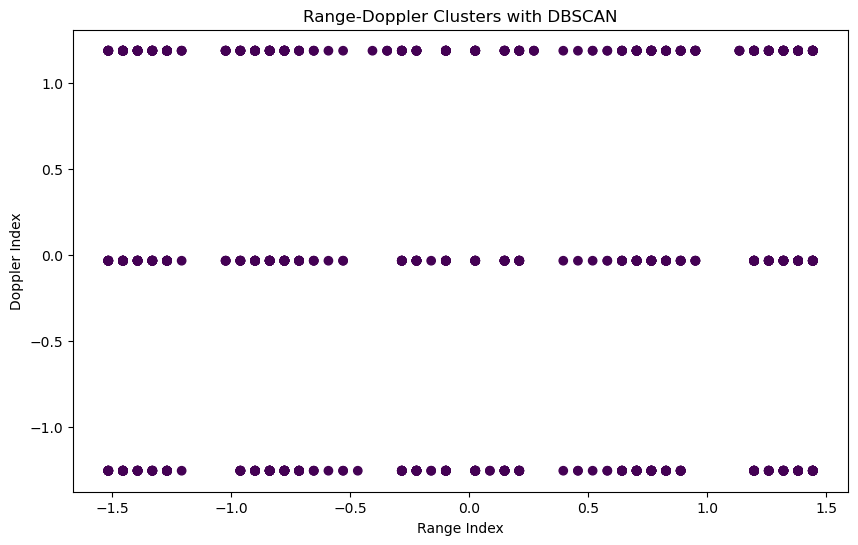

Estimated number of people: 1


In [65]:
# Feature Scaling
scaler = StandardScaler()
significant_points_scaled = scaler.fit_transform(significant_points)

# Apply DBSCAN Clustering, which does not require specifying the number of clusters
dbscan = DBSCAN(eps=1.5, min_samples=10)  # Adjust the eps and min_samples parameters as needed
dbscan.fit(significant_points_scaled)

# Filter out noise points and get the labels
labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(significant_points_scaled[labels != -1, 0], significant_points_scaled[labels != -1, 1], c=labels[labels != -1], cmap='viridis')
plt.title('Range-Doppler Clusters with DBSCAN')
plt.xlabel('Range Index')
plt.ylabel('Doppler Index')
plt.show()

# Estimating the number of people
num_people = num_clusters
print(f'Estimated number of people: {num_people}')

Estimated number of people: 1
